Ноутбук с подготовкой новостных статей к задаче моделирования


* 1. Сравнение оригинальных и переписанных статей

* 2. Объединение тренировочного и тестового датасета

* 3. Обработка датасета

* 4. Статистический анализ

* 5. Аугментация новостей и их нарезка статей

* 6. Обрежем длинные новости

* 7. Итоговые статистики

In [52]:
from nltk.tokenize import sent_tokenize, word_tokenize
from utils_for_colab import try_load, save_s3
from nltk.corpus import wordnet
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from copy import deepcopy
from minio import Minio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import nltk
import os
import re

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

In [53]:
load_dotenv()

YANDEX_CLOUD_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
YANDEX_CLOUD_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

BUCKET_NAME = 'graduate' # s3

PATH = '/Users/dan/git_repo/graduate/'

In [54]:
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [13]:
# Статьи The Guardian переписанные DSv3
dsv3_cycle_rewrite_from_orig = try_load(
    file_path=PATH+'data/',
    file_name='dsv3_cycle_rewrite_from_orig.pkl',
    client_s3=client_s3
    )

# Статьи NYT переписанные DSv3
papers_nyt_rewrite_news = try_load(
    file_path=PATH+'data/',
    file_name='papers_nyt_rewrite_news.pkl',
    client_s3=client_s3
    )

# Статьи переписанные PHI 3.5
phi3_5_if_texts_processed_dsv3 = try_load(
    file_path=PATH+'data/',
    file_name='phi3_5_if_texts_processed_dsv3.pkl',
    client_s3=client_s3
    )

# Статьи переписанные Gemeni Flash 2.0
gemeni_flash_2_rewrite_the_guardian = try_load(
    file_path=PATH+'data/',
    file_name='gemeni_flash_2_rewrite_the_guardian.pkl',
    client_s3=client_s3
    )

# Статья сгенерированная DeepSeek-V3
deepseek_write_papers = try_load(
    file_path=PATH+'data/',
    file_name='deepseek_write_papers.pkl',
    client_s3=client_s3
    )

# Оригинальные статьи
the_guardian_clean_politic_news_03052025 = try_load(
    file_path=PATH+'data/',
    file_name='the_guardian_clean_politic_news_03052025.pkl',
    client_s3=client_s3
    )



In [14]:
# Статьи переписанные Gemeni Flash 2.0
gemeni_flash_2_rewrite_the_guardian = try_load(
    file_path=PATH+'data/',
    file_name='gemeni_flash_2_rewrite_the_guardian.pkl',
    client_s3=client_s3
    )

# 1. Сравнение оригинальных и переписанных статей

In [17]:
the_guardian_intersect = np.intersect1d(
    list(dsv3_cycle_rewrite_from_orig.keys()),
    list(phi3_5_if_texts_processed_dsv3.keys()),
    list(gemeni_flash_2_rewrite_the_guardian.keys())
)

len(the_guardian_intersect)

1000

In [18]:
key0 = the_guardian_intersect[0]
key10 = the_guardian_intersect[10]
key100 = the_guardian_intersect[100]
key500 = the_guardian_intersect[500]

key5 = the_guardian_intersect[5]
key15 = the_guardian_intersect[15]
key105 = the_guardian_intersect[105]
key505 = the_guardian_intersect[505]

In [27]:
dsv3_cycle_rewrite_from_orig[key15]

['India is demanding an exemption from the UK’s planned carbon tax as part of negotiations aiming to finalise a free trade deal before the UK election.\nIndia’s negotiating team have spent this week in London in a surprise set of talks to try to overcome the remaining hurdles to an agreement.\nRishi Sunak is eager to get the trade deal over the line and had hoped to clinch it last month.\nIndia has used the limited time Sunak has left before a general election as a bargaining chip. A UK government official said Indian negotiators were “saying they have five years to plan ahead, this government has five months”.\nThe talks are taking place as India’s six-week general election campaign, starting on Friday, is about to get under way. Opinion polls in India suggest Narendra Modi’s Bharatiya Janata party will win for the third time running. UK polling, meanwhile, suggests Sunak’s Conservative party is on course for a defeat.\nIndia’s commerce minister said on Monday that there were “very fe

In [30]:
# [ноут сравнения статей v1]
i = 3
print(f'Оригинальная статья {i}:\n{dsv3_cycle_rewrite_from_orig[key505][0]}')
print(f'Сгенерирвоанная статья {i} версия 1:\n{dsv3_cycle_rewrite_from_orig[key505][1]}')
print(f'Сгенерирвоанная статья {i} версия 2:\n{dsv3_cycle_rewrite_from_orig[key505][3]}')
print(f'Сгенерирвоанная статья {i} версия 3:\n{dsv3_cycle_rewrite_from_orig[key505][5]}')
print(f'Сгенерирвоанная статья {i} версия 5:\n{dsv3_cycle_rewrite_from_orig[key505][7]}')
print(f'Сгенерирвоанная статья {i} версия 6:\n{dsv3_cycle_rewrite_from_orig[key505][8]}')
print(f'Сгенерирвоанная статья {i} версия 7:\n{dsv3_cycle_rewrite_from_orig[key505][9]}')

Оригинальная статья 3:
Labour’s advance and the Tories’ collapse look set to break records on 4 July, but so does the silent surge for “someone else”. The combined Labour and Conservative  for Labour – ignore these growing noises off at your peril. They can take centre stage faster than you think.
This brings us to the final piece of our electoral puzzle: the Greens. Squeezed by Corbyn, under co-leaders Carla Denyer and Adrian Ramsay they are flourishing again after Starmer’s move to the centre, with several outstanding rounds of local election results, a record slate of candidates and a solid 5% in the polls, which if sustained would be easily their best general election performance. The Greens start too weak to compete in most places, let alone win outright, but they could become the main local opposition in many safe Labour areas. The Greens have come a long way since the last Labour government, when they were barely a rounding error in polls, and could mature into a formidable elec

## 1.1 [ноут сравнения статей v1]

In [19]:
# [ноут сравнения статей v1]
print(f'Paper 1:\n{dsv3_cycle_rewrite_from_orig[key0][0]}')
print(f'Paper 2:\n{dsv3_cycle_rewrite_from_orig[key0][-1]}')
print(f'Paper 3:\n{phi3_5_if_texts_processed_dsv3[key0][1]}')
print(f'Paper 4:\n{gemeni_flash_2_rewrite_the_guardian[key0][-1]}')

Paper 1:
After more than three years of delays, Tuesday finally sees the introduction of physical checks on animal and plant imports coming into Britain from the EU.
Importers and trade associations have warned that the new bureaucracy could heap significant costs on to importers, resulting in increases to prices on shop shelves.
But what exactly are the new checks coming in, and what impact will they have on businesses and the consumer? Here is a rundown of what to expect.
What are the new checks? The new regime will mirror checks brought in by the EU when the UK left the single market in January 2021.
They make up the second stage of the government’s Border Target Operating Model (BTOM) plan.
The first phase, which was introduced on 31 January this year, introduced new requirements which meant the majority of meat, dairy and plant products require a health certificate before they can enter the Britain.
The second phase, beginning on Tuesday, will be the most significant, with lorries

In [ ]:
# [ноут сравнения статей v1]
print(f'Paper 1:\n{dsv3_cycle_rewrite_from_orig[key10][0]}')
print(f'Paper 2:\n{dsv3_cycle_rewrite_from_orig[key10][-1]}')
print(f'Paper 3:\n{phi3_5_if_texts_processed_dsv3[key10][1]}')
print(f'Paper 4:\n{gemeni_flash_2_rewrite_the_guardian[key10][-1]}')

Paper 1:
I have voted in every general and local election since 1959, but I won’t be voting on 2 May. Not because I have lost faith in politics, but because my postal vote never arrived. When I phoned the electoral service office of my local authority on 26 April, I was told it would arrive within the next two days. It didn’t, so I phoned the office again on 29 April and was told I would have to go to the civic centre, which is several miles away, to be able to vote.
I pointed out that I had applied for a postal vote as I have very limited mobility and had no way of getting to the civic centre, as I no longer drive and I have no one who could go on my behalf. I asked if my vote could be brought to me. Answer: no. Why not? Security. I asked if, in the event that I could get to my local polling station, I would be able to vote. Again no, because I had requested a postal vote.
So I am being deprived of my democratic right to vote because there is no plan B in the event of a lost or not se

## 1.2 [ноут сравнения статей v2]

In [ ]:
# [ноут сравнения статей v2]
print(f'Paper 1:\n{dsv3_cycle_rewrite_from_orig[key100][-1]}')
print(f'Paper 2:\n{dsv3_cycle_rewrite_from_orig[key100][0]}')
print(f'Paper 3:\n{phi3_5_if_texts_processed_dsv3[key100][1]}')
print(f'Paper 4:\n{gemeni_flash_2_rewrite_the_guardian[key100][-1]}')

Paper 1:
As Labour finalizes its plans for Great British Energy (GB Energy), the proposed state-backed energy company represents the most significant intervention in Britain’s power market since the privatizations of the 1980s and 1990s. With an £8 billion commitment, the policy aims to transition the UK toward renewable energy while addressing long-standing inefficiencies in the sector. However, the scale of the challenge—and the political and economic hurdles—raises questions about its feasibility and impact.
Unlike traditional nationalized utilities, GB Energy will not operate as a direct energy supplier. Instead, it will function as a strategic investor in renewable projects, targeting areas where private capital has been reluctant to engage due to long payback periods. These include offshore wind farms, localized solar initiatives, and experimental technologies such as small modular nuclear reactors and green hydrogen. The company will be headquartered in Scotland, a symbolic choi

In [ ]:
# [ноут сравнения статей v2]
print(f'Paper 1:\n{dsv3_cycle_rewrite_from_orig[key500][-1]}')
print(f'Paper 2:\n{dsv3_cycle_rewrite_from_orig[key500][0]}')
print(f'Paper 3:\n{phi3_5_if_texts_processed_dsv3[key500][1]}')
print(f'Paper 4:\n{gemeni_flash_2_rewrite_the_guardian[key500][-1]}')

Paper 1:
The Conservative Party has suffered a significant setback in England’s local elections, with Labour securing decisive victories in councils and mayoral contests that were once considered Tory strongholds. The results have exposed deepening divisions within the Conservative Party, leaving Prime Minister Rishi Sunak under mounting pressure to stabilize his government ahead of an anticipated general election later this year.
Labour’s gains were substantial, with the party capturing more than 200 council seats, surpassing the 1,000-seat threshold for the first time in years. Meanwhile, the Conservatives lost 370 seats, dropping them behind the Liberal Democrats in local representation—a position they have not held in decades. Sir John Curtice, a leading political analyst, described the results as the Conservative Party’s worst local election performance since the 1980s, with Labour’s projected national vote share exceeding the Tories’ by nine percentage points.
One of the most str

## 1.3 [ноут сравнения статей v3]

In [ ]:
# [ноут сравнения статей v3]
print(f'Paper 1:\n{dsv3_cycle_rewrite_from_orig[key505][-1]}')
print(f'Paper 2:\n{dsv3_cycle_rewrite_from_orig[key505][-2]}')
print(f'Paper 3:\n{dsv3_cycle_rewrite_from_orig[key505][-3]}')
print(f'Paper 4:\n{dsv3_cycle_rewrite_from_orig[key505][-5]}')
print(f'Paper 5:\n{dsv3_cycle_rewrite_from_orig[key505][0]}')

Paper 1:
The ongoing employment tribunal involving Josie Stewart, a mid-level Foreign, Commonwealth & Development Office (FCDO) policy advisor, has exposed systemic failures in the UK government’s response to the 2021 Kabul evacuation. Internal documents presented as evidence reveal a chaotic operation in which bureaucratic inefficiencies and questionable decision-making led to preventable human suffering—while resources were diverted to non-essential evacuations. The case has sparked a broader debate about government accountability, whistleblower protections, and the ethical obligations of civil servants during crises.
Ms. Stewart, a career civil servant with a decade of service, became an unlikely whistleblower after witnessing what she described as a profound moral failure in the UK’s evacuation efforts. Leaked internal communications—emails marked "SECRET" and bearing timestamps from the height of the crisis—paint a picture of disarray. Spreadsheets tracking Afghan nationals eligib

In [ ]:
# [ноут сравнения статей v3]
print(f'Paper 1:\n{dsv3_cycle_rewrite_from_orig[key5][-1]}')
print(f'Paper 2:\n{dsv3_cycle_rewrite_from_orig[key5][-2]}')
print(f'Paper 3:\n{dsv3_cycle_rewrite_from_orig[key5][-3]}')
print(f'Paper 4:\n{dsv3_cycle_rewrite_from_orig[key5][-5]}')
print(f'Paper 5:\n{dsv3_cycle_rewrite_from_orig[key5][0]}')

Paper 1:
The 2024 UK general election campaign has been defined by a series of tactical errors, policy reversals, and public relations misjudgments, raising questions about the effectiveness of both major parties’ strategies. Prime Minister Rishi Sunak’s Conservative Party has faced repeated setbacks, while Labour’s disciplined but risk-averse approach has drawn criticism for lacking dynamism. Meanwhile, the Liberal Democrats’ attempts to capture public attention have struggled to translate into substantive policy engagement.
Mr. Sunak’s decision to call an early July election was immediately overshadowed by logistical and symbolic missteps. His announcement, delivered in heavy rain while protesters played Labour’s 1997 campaign anthem, *Things Can Only Get Better*, set an inauspicious tone for the Conservative campaign. Since then, policy rollouts have been undermined by internal contradictions and public skepticism.
The Prime Minister’s proposal to reintroduce national service for 18

# 2. Объединение тренировочного и тестового датасета

In [7]:
# Соберем все статьи в таблицу
news_dataset = pd.DataFrame()

In [8]:
# Статьи The Guardian переписанные DSv3
dsv3_cycle_rewrite_from_orig_keys = list(dsv3_cycle_rewrite_from_orig.keys())

for key in dsv3_cycle_rewrite_from_orig_keys:
    curr_iter = dsv3_cycle_rewrite_from_orig[key]
    original = curr_iter[0] # original
    generated_v1 = curr_iter[1] # genereted_v1
    generated_v2 = curr_iter[3] # genereted_v2
    generated_v3 = curr_iter[5] # genereted_v3
    generated_v4 = curr_iter[7] # genereted_v4
    generated_v5 = curr_iter[8] # genereted_v5
    generated_v6 = curr_iter[9] # genereted_v6

    cur_df = pd.DataFrame({
        'key' : [key]*7,
        'describ' : [
            'guardian_orig', 'guardian_rw_dsv3_1', 'guardian_rw_dsv3_2', 'guardian_rw_dsv3_3', 'guardian_rw_dsv3_4', 'guardian_rw_dsv3_5', 'guardian_rw_dsv3_6'
            ],
        'paper' : [
            original, generated_v1, generated_v2, generated_v3, generated_v4, generated_v5, generated_v6
            ],
        'generated_flg' : [
            0, 1, 1, 1, 1, 1, 1
        ]
    })

    news_dataset = pd.concat([news_dataset, cur_df])

In [9]:
# Статьи NYT переписанные DSv3
papers_nyt_rewrite_news_keys = list(papers_nyt_rewrite_news.keys())

for key in papers_nyt_rewrite_news_keys:
    curr_iter = papers_nyt_rewrite_news[key]
    original = curr_iter[0] # original
    generated_v1 = curr_iter[1] # genereted_v1
    generated_v2 = curr_iter[3] # genereted_v2
    generated_v3 = curr_iter[5] # genereted_v3
    generated_v4 = curr_iter[7] # genereted_v4

    cur_df = pd.DataFrame({
        'key' : [key]*5,
        'describ' : [
            'nyt_orig', 'nyt_rw_dsv3_1', 'nyt_rw_dsv3_2', 'nyt_rw_dsv3_3', 'nyt_rw_dsv3_4'
            ],
        'paper' : [
            original, generated_v1, generated_v2, generated_v3, generated_v4
            ],
        'generated_flg' : [
            0, 1, 1, 1, 1
        ]
    })

    news_dataset = pd.concat([news_dataset, cur_df])

In [10]:
# Статьи переписанные PHI 3.5
phi3_5_if_texts_processed_dsv3_keys = list(phi3_5_if_texts_processed_dsv3.keys())

for key in phi3_5_if_texts_processed_dsv3_keys:
    curr_iter = phi3_5_if_texts_processed_dsv3[key]
    generated_v1 = curr_iter[1] # genereted_v1

    cur_df = pd.DataFrame({
        'key' : [key],
        'describ' : ['guardian_rw_phi_35'],
        'paper' : [generated_v1],
        'generated_flg' : [1]
    })

    news_dataset = pd.concat([news_dataset, cur_df])

In [11]:
# # Статья сгенерированная DeepSeek-V3
deepseek_write_papers_keys = list(deepseek_write_papers.keys())

for key in deepseek_write_papers_keys:
    curr_iter = deepseek_write_papers[key]
    generated_v1 = curr_iter[0] # genereted_v1
    generated_v2 = curr_iter[2] # genereted_v2

    cur_df = pd.DataFrame({
        'key' : [key]*2,
        'describ' : ['dsv3_news_1', 'dsv3_news_2'],
        'paper' : [generated_v1, generated_v2],
        'generated_flg' : [1, 1]
    })

    news_dataset = pd.concat([news_dataset, cur_df])

In [12]:
# Оригинальные новости The Guardian
the_guardian_clean_politic_news_03052025_keys = list(the_guardian_clean_politic_news_03052025.keys())

diff_orig_papers_keys = np.setdiff1d(
    the_guardian_clean_politic_news_03052025_keys,
    news_dataset[news_dataset['generated_flg']==0]['key'].values
)

for key in diff_orig_papers_keys:
    curr_iter = the_guardian_clean_politic_news_03052025[key]
    original = curr_iter[1]

    cur_df = pd.DataFrame({
        'key' : [key],
        'describ' : ['guardian_orig'],
        'paper' : [original],
        'generated_flg' : [0]
    })

    news_dataset = pd.concat([news_dataset, cur_df])

In [13]:
# Переписанные новости gemeni The Guardian
gemeni_flash_2_rewrite_the_guardian_keys = list(gemeni_flash_2_rewrite_the_guardian.keys())

for key in gemeni_flash_2_rewrite_the_guardian_keys:
    curr_iter = gemeni_flash_2_rewrite_the_guardian[key]
    generated_v1 = curr_iter[1] # genereted_v1
    generated_v2 = curr_iter[3] # genereted_v2

    cur_df = pd.DataFrame({
        'key' : [key]*2,
        'describ' : ['guardian_rw_gemeni_1', 'guardian_rw_gemeni_2'],
        'paper' : [generated_v1, generated_v2],
        'generated_flg' : [1, 1]
    })

    news_dataset = pd.concat([news_dataset, cur_df])

In [14]:
news_dataset.groupby('describ')['generated_flg'].agg(['count', 'mean'])

,count,mean
describ,,
dsv3_news_1,549,1.0
dsv3_news_2,549,1.0
guardian_orig,5200,0.0
guardian_rw_dsv3_1,890,1.0
guardian_rw_dsv3_2,890,1.0
guardian_rw_dsv3_3,890,1.0
guardian_rw_dsv3_4,890,1.0
guardian_rw_dsv3_5,890,1.0
guardian_rw_dsv3_6,890,1.0


In [15]:
news_dataset['generated_flg'].mean()

np.float64(0.7672497935280427)

# 3. Обработка датасета

In [17]:
news_dataset = news_dataset.reset_index(drop=True)
news_dataset

,key,describ,paper,generated_flg
0,politics/article/2024/jun/27/reform-uk-activis...,guardian_orig,A Reform UK activist in the constituency where...,0
1,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_1,The Reform UK party has been plunged into fres...,1
2,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_2,"The seaside town of Clacton-on-Sea, where Nige...",1
3,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_3,Undercover footage from Nigel Farage’s Reform ...,1
4,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_4,The pub chatter in Clacton-on-Sea took a dark ...,1
...,...,...,...,...
26633,politics/2023/oct/15/rachel-reeves-says-labour...,guardian_rw_gemeni_2,"TAMWORTH, Staffs — Shadow Chancellor Rachel Re...",1
26634,politics/2023/oct/15/labour-to-omit-social-car...,guardian_rw_gemeni_1,As the Labour Party gears up for the next gene...,1
26635,politics/2023/oct/15/labour-to-omit-social-car...,guardian_rw_gemeni_2,"As the next general election looms, the Labour...",1
26636,politics/2023/oct/14/glitter-bomb-bounce-makes...,guardian_rw_gemeni_1,A recent Observer poll indicates that Keir Sta...,1


In [18]:
# Удалим короткие новости
del_row = set()
for idx in news_dataset.index:
    if len(news_dataset.loc[idx, 'paper'].split()) < 150:
        del_row.add(idx)

news_dataset = news_dataset[~news_dataset.index.isin(del_row)].reset_index(drop=True)

In [19]:
# Удалим спецсимволы и пробелы из статей
for idx in news_dataset.index:
    text = news_dataset.loc[idx, 'paper']

    # Убираем спецсимволы
    text = re.sub(r"[{}[\]#*/\\|<>;]", "", text)
    # Убираем переносы строк
    text = re.sub(r"\n", " ", text)
    # Приводим несколько пробелов подряд к одному
    text = re.sub(r"\s{2,}", " ", text)
    # Убираем начальные и конечные пробелы
    text = text.strip()

    news_dataset.loc[idx, 'paper'] = text

In [20]:
news_dataset

,key,describ,paper,generated_flg
0,politics/article/2024/jun/27/reform-uk-activis...,guardian_orig,A Reform UK activist in the constituency where...,0
1,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_1,The Reform UK party has been plunged into fres...,1
2,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_2,"The seaside town of Clacton-on-Sea, where Nige...",1
3,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_3,Undercover footage from Nigel Farage’s Reform ...,1
4,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_4,The pub chatter in Clacton-on-Sea took a dark ...,1
...,...,...,...,...
26553,politics/2023/oct/15/rachel-reeves-says-labour...,guardian_rw_gemeni_2,"TAMWORTH, Staffs — Shadow Chancellor Rachel Re...",1
26554,politics/2023/oct/15/labour-to-omit-social-car...,guardian_rw_gemeni_1,As the Labour Party gears up for the next gene...,1
26555,politics/2023/oct/15/labour-to-omit-social-car...,guardian_rw_gemeni_2,"As the next general election looms, the Labour...",1
26556,politics/2023/oct/14/glitter-bomb-bounce-makes...,guardian_rw_gemeni_1,A recent Observer poll indicates that Keir Sta...,1


# 4. Статистический анализ

In [22]:
def lexical_diversity(text: str) -> float:
    """Вычисляет лексическое разнообразие текста.

    text : Исходный текст.
    return : Лексическое разнообразие.
    """
    words = word_tokenize(text)
    unique_words = set(words)
    return len(unique_words) / len(words)

In [ ]:
# Рассчет
lexical_diverity_data = {}

for type_paper in tqdm(news_dataset['describ'].unique()):

  paper_array = news_dataset[news_dataset['describ']==type_paper]['paper'].values
  lexical_diverity_data[type_paper] = list()

  for paper in paper_array:
    lexical_diverity_data[type_paper].append(
        lexical_diversity(paper)
    )

In [25]:
gen_type_map = {
    'guardian_orig' : 'Оригинальные новости The Guardian',
    'guardian_rw_dsv3_1' : 'Новости The Guardian переписанные \nDeepSeek-v3 версия 1',
    'guardian_rw_dsv3_2' : 'Новости The Guardian переписанные \nDeepSeek-v3 версия 2',
    'guardian_rw_dsv3_3' : 'Новости The Guardian переписанные \nDeepSeek-v3 версия 3',
    'guardian_rw_dsv3_4' : 'Новости The Guardian переписанные \nDeepSeek-v3 версия 4',
    'guardian_rw_dsv3_5' : 'Новости The Guardian переписанные \nDeepSeek-v3 версия 5',
    'guardian_rw_dsv3_6' : 'Новости The Guardian переписанные \nDeepSeek-v3 версия 6',
    'nyt_orig' : 'Оригинальные новости New York Times',
    'nyt_rw_dsv3_1' : 'Новости New York Times переписанные \nDeepSeek-v3 версия 1',
    'nyt_rw_dsv3_2' : 'Новости New York Times переписанные \nDeepSeek-v3 версия 2',
    'nyt_rw_dsv3_3' : 'Новости New York Times переписанные \nDeepSeek-v3 версия 3',
    'nyt_rw_dsv3_4' : 'Новости New York Times переписанные \nDeepSeek-v3 версия 4',
    'guardian_rw_phi_35' : 'Новости The Guardian переписанные \nPHI 3.5 версия 6',
    'dsv3_news_1' : 'Новости сгенерированные \nDeepSeek-v3 версия 1',
    'dsv3_news_2' : 'Новости сгенерированные \nDeepSeek-v3 версия 2',
    'guardian_rw_gemeni_1' : 'Новости The Guardian переписанные \nGemeni 2 flash версия 1',
    'guardian_rw_gemeni_2' : 'Новости The Guardian переписанные \nGemeni 2 flash версия 2'
}

In [49]:
data = {
'Оригинальные новости Guardian' : 0.44,
'Новости Guardian переписанные\n[DeepSeek-v3]' : 0.53,
'Новости Guardian переписанные\n[DeepSeek-v3 RI-1]' : 0.57,
'Новости Guardian переписанные\n[DeepSeek-v3 RI-2]' : 0.57,
'Новости Guardian переписанные\n[DeepSeek-v3 RI-3]' : 0.59,
'Новости Guardian переписанные\n[DeepSeek-v3 RI-4]' : 0.55,
'Новости Guardian переписанные\n[DeepSeek-v3 RI-5]' : 0.55,
'Оригинальные новости NYT' : 0.52,
'Новости NYT переписанные\n[DeepSeek-v3]' : 0.56 ,
'Новости NYT переписанные\n[DeepSeek-v3 RI-1]' : 0.58,
'Новости NYT переписанные\n[DeepSeek-v3 RI-2]' : 0.58,
'Новости NYT переписанные\n[DeepSeek-v3 RI-3]' : 0.60,
'Новости The Guardian\nпереписанные [PHI 3.5]' : 0.61,
'Новости сгенерированные\n[DeepSeek-v3]' : 0.57,
'Новости сгенерированные\n[DeepSeek-v3 RI-1]' : 0.66,
'Новости Guardian переписанные\n[Gemeni 2 flash]' : 0.48,
'Новости Guardian переписанные\n[Gemeni 2 flash RI-1]' : 0.48
}

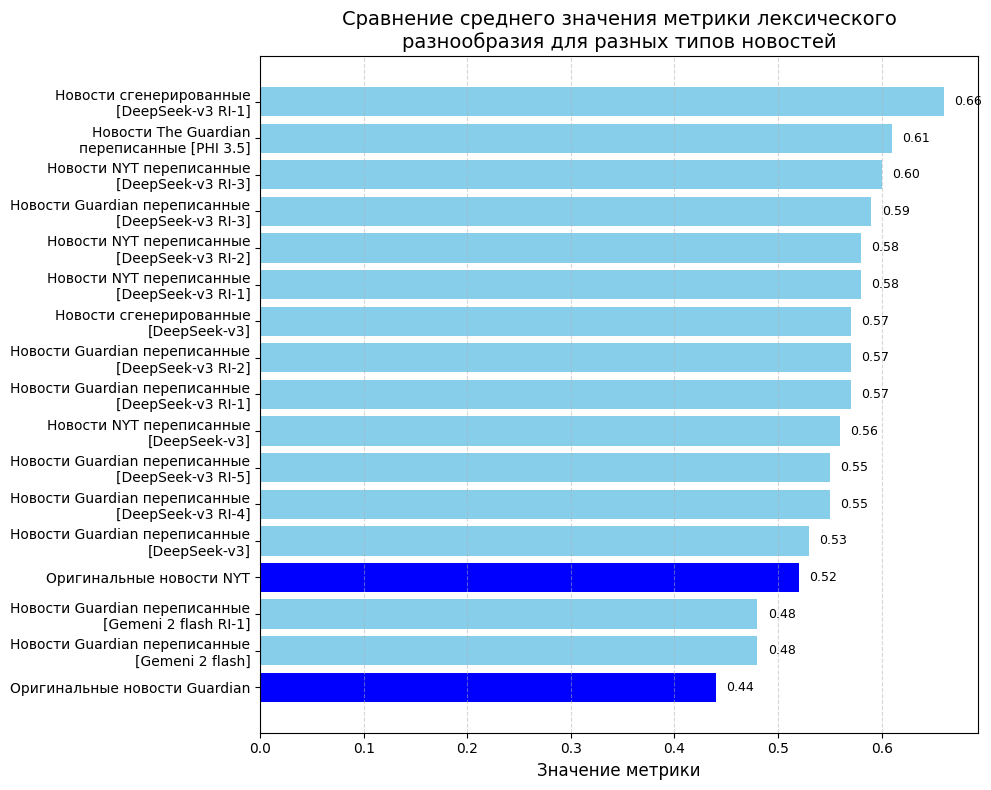

In [50]:
# Сортировка данных по значениям
sorted_data = dict(sorted(data.items(), key=lambda item: item[1]))

# Создаем список цветов (по умолчанию 'skyblue', а нужный элемент — 'blue')
colors = ['skyblue'] * len(sorted_data)
highlight_key = ['Оригинальные новости NYT', 'Оригинальные новости Guardian']

# Находим индекс нужного элемента и меняем его цвет
for orig in highlight_key:
    index = list(sorted_data.keys()).index(orig)
    colors[index] = 'blue'  # Меняем цвет на синий

# Строим график
plt.figure(figsize=(10, 8))
bars = plt.barh(list(sorted_data.keys()), list(sorted_data.values()), color=colors)

# Добавляем подписи значений
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f"{width:.2f}", 
             va='center', ha='left', fontsize=9)

plt.xlabel('Значение метрики', fontsize=12)
plt.title('Сравнение среднего значения метрики лексического\nразнообразия для разных типов новостей', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

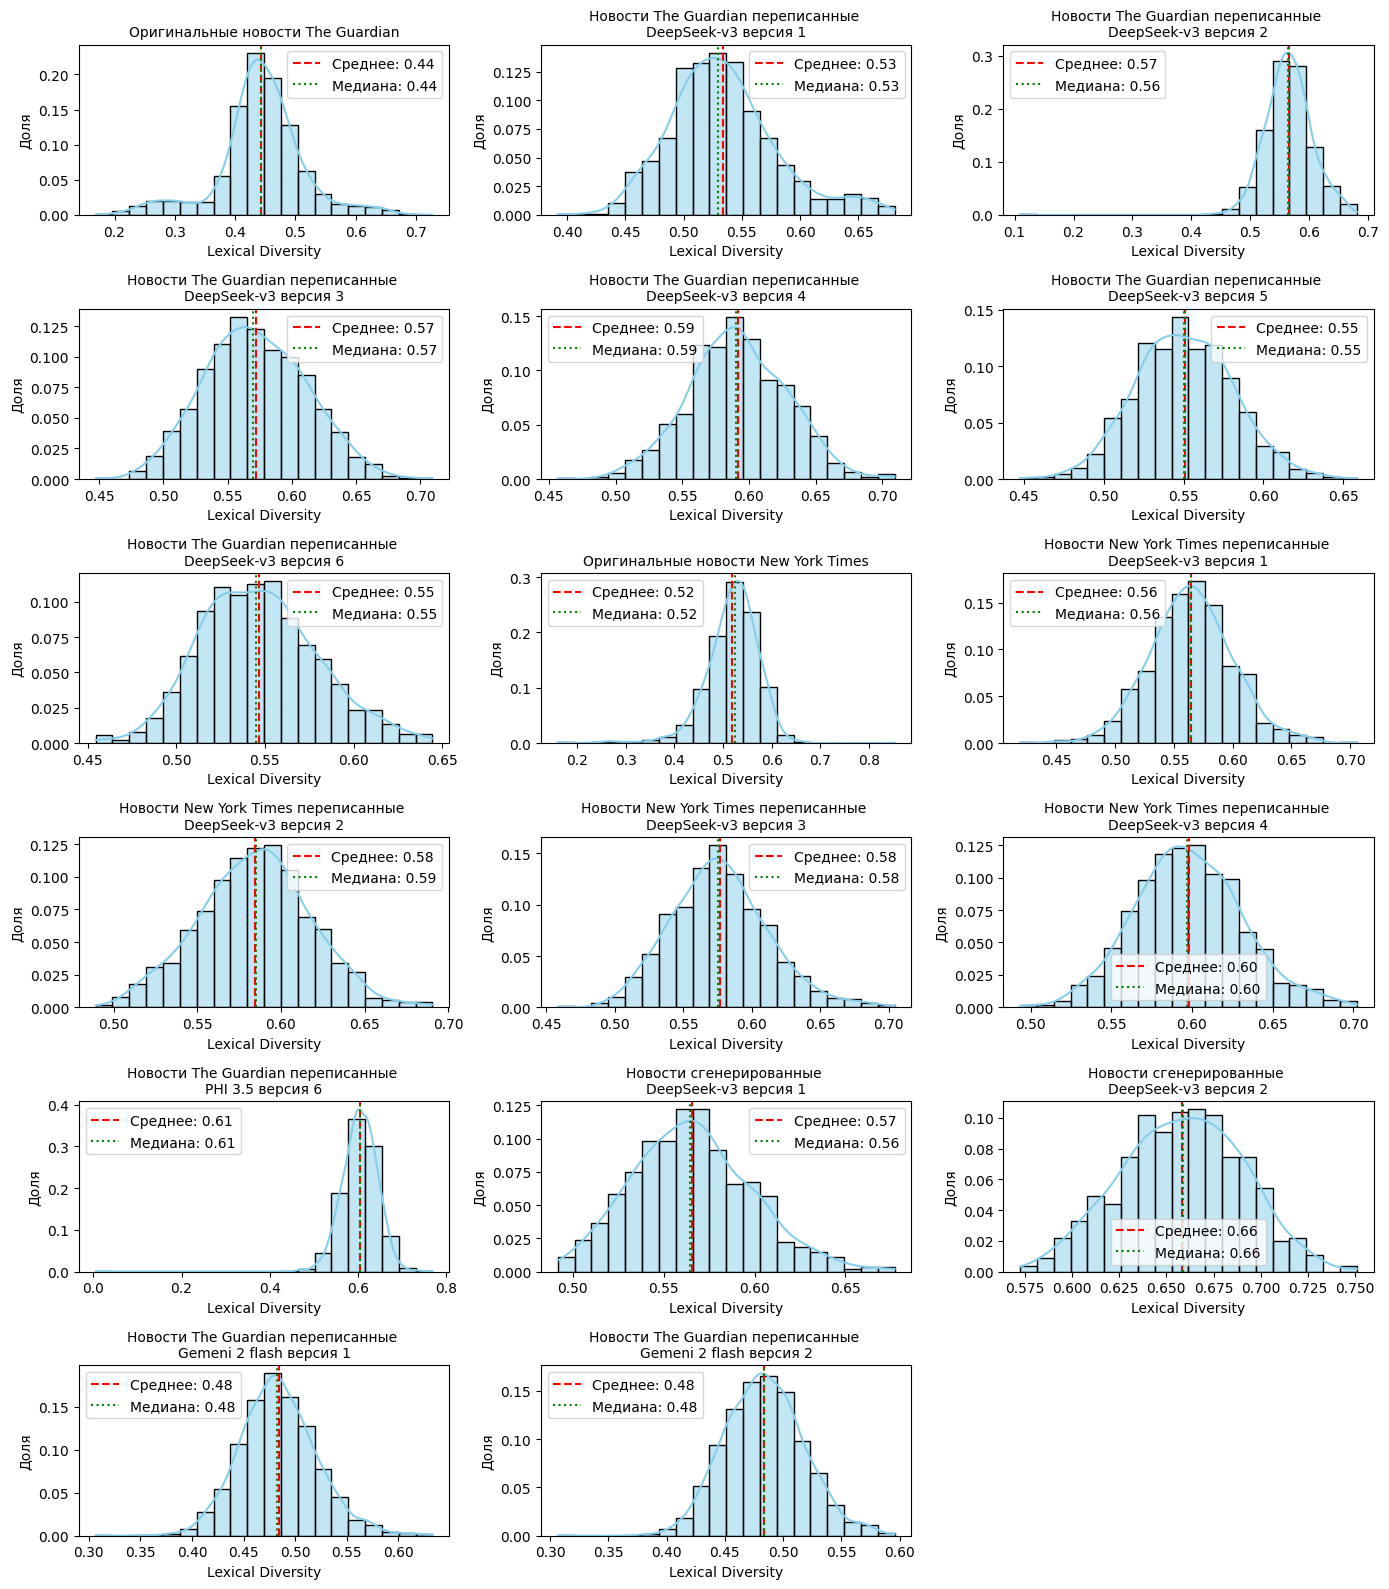

In [26]:
# Построение 15 графиков с распределением помоценке лексического разнообразия
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(14, 16))
axes = axes.flatten()

for idx, gen_type in enumerate(lexical_diverity_data.keys()):
    ax = axes[idx]
    values = lexical_diverity_data[gen_type]
    gen_type = gen_type_map[gen_type]

    sns.histplot(values, kde=True, ax=ax, bins=20, color='skyblue', edgecolor='black', stat='probability')
    mean_val = np.mean(values)
    median_val = np.median(values)

    ax.axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle=':', label=f'Медиана: {median_val:.2f}')
    ax.set_title(gen_type, fontsize=10)
    ax.set_xlabel('Lexical Diversity')
    ax.set_ylabel('Доля')
    ax.legend()

# Удалим лишние оси, если количество подграфиков меньше 15
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 5. Аугментация новостей и их нарезка статей

In [29]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace('_', ' ')
            if w.lower() != word.lower():
                synonyms.add(w)
    return list(synonyms)

def eda_sentence(sentence,
                 alpha_sr=0.05,
                 alpha_ri=0.05,
                 alpha_rs=0.05,
                 p_rd=0.05):
    words = word_tokenize(sentence)
    if len(words) < 4:
        return sentence  # слишком короткое — не аугментируем

    n = len(words)
    num_sr = max(1, int(alpha_sr * n))
    num_ri = max(1, int(alpha_ri * n))
    num_rs = max(1, int(alpha_rs * n))

    out = deepcopy(words)

    # Synonym Replacement
    idxs = list(range(len(out)))
    random.shuffle(idxs)
    replaced = 0
    for i in idxs:
        syns = get_synonyms(out[i])
        if syns:
            out[i] = random.choice(syns)
            replaced += 1
            if replaced >= num_sr:
                break

    # Random Insertion
    for _ in range(num_ri):
        if len(out) == 0:
            break
        idx = random.randrange(len(out))
        syns = get_synonyms(out[idx])
        if syns:
            out.insert(idx, random.choice(syns))

    # Random Swap (with length check)
    if len(out) >= 2:
        for _ in range(num_rs):
            if len(out) < 2:
                break
            i, j = random.sample(range(len(out)), 2)
            out[i], out[j] = out[j], out[i]

    # Random Deletion
    out = [w for w in out if random.random() > p_rd]
    if len(out) < 1:
        return sentence
    return ' '.join(out)



def truncate_to_n_words(text: str, start: int = 0, max_words: int = 512) -> str:
    tokens = text.split()
    if len(tokens) <= max_words:
        return text
    return " ".join(tokens[start:max_words])

def augment_long_doc(doc: str,
                     num_augmented: int = 3,
                     sentence_pct: float = 0.2,
                     max_words: int = 512,
                     start:int = 0,
                     **eda_kwargs):
    """
    Для длинных документов:
     - разбивает на предложения,
     - выбирает случайно sentence_pct долю предложений для агументации,
     - генерирует num_augmented копий.
    """
    doc = truncate_to_n_words(doc, max_words=max_words)
    sents = sent_tokenize(doc)
    m = len(sents)
    k = max(1, int(sentence_pct * m))

    augmented = []
    for _ in range(num_augmented):
        chosen = set(random.sample(range(m), k))
        new_sents = []
        for i, sent in enumerate(sents):
            if i in chosen:
                new_sents.append(eda_sentence(sent, **eda_kwargs))
            else:
                new_sents.append(sent)
        augmented.append(' '.join(new_sents))
    return augmented

In [30]:
# Пометим старые данные как данные без аугментации
news_dataset['augment_data'] = 0

In [31]:
# Список с аугментированными статьями
new_data = []

for idx in tqdm(news_dataset.index):

    row = news_dataset.loc[idx]

    new_paper = augment_long_doc(
        row['paper'],
        num_augmented=1,
        start=0,
        max_words=1024,
        alpha_sr=0.2,
        alpha_ri=0.15,
        alpha_rs=0.05,
        p_rd=0.05
        )

    new_data.append(
        {
            'key' : row['key'],
            'describ' : row['describ'],
            'paper' : new_paper[0],
            'generated_flg' : row['generated_flg'],
            'augment_data' : 1
        }
    )

  0%|          | 0/26558 [00:00<?, ?it/s]

In [32]:
# Пример применения аугментации
new_data = pd.DataFrame(new_data)

key = new_data['key'][0]
describ = new_data['describ'][0]

print(new_data['paper'][0])
print(news_dataset[(news_dataset['key']==key)&(news_dataset['describ']==describ)]['paper'][0])

A Reform UK activist in the constituency where Nigel Farage is standing has been secretly filmed making extremely racist comments about Rishi Sunak, as well as using Islamophobic and other offensive language. Farage said he was “dismayed” by the views expressed by Andrew Parker, a Reform canvasser, who was filmed as part of an undercover investigation by Channel 4 News. The channel also secretly filmed George Jones, a longtime party activist who organises events for Farage, making homophobic comments, calling the Pride flag “degenerate” and LGBT people “nonces”. The emergence of the footage, filming of which concluded last week, comes on the same day that Reform dropped an election candidate in another seat, after the Guardian informed the party that Raymond Saint had been on a list of members of the British National party. The most serious comments uncovered by Channel 4 News involved Parker, who was covertly filmed making them while canvassing and travelling by car around Clacton, wh

In [33]:
# Добавим аугментированные данные в датасет
news_dataset = pd.concat([news_dataset, new_data])

news_dataset = news_dataset.reset_index(drop=True)

In [34]:
news_dataset['augment_data'].mean()

np.float64(0.5)

# 6. Обрежем длинные новости

In [64]:
def print_statistic(array_len:list, titile:str):
  len_papers = pd.Series(array_len)

  len_mean, len_median, len_q05, len_q95 =\
    len_papers.mean(), len_papers.median(), len_papers.quantile(0.05), len_papers.quantile(0.95)

  print(titile)
  print(f'Среднее: {len_mean:.2f}, медиана: {len_median:.2f}, квантиль 0,05: {len_q05:.2f}, квантиль 0,95: {len_q95:.2f}', '\n')

In [58]:
# Оригинальные статьи
news_dataset = try_load(
    file_path=PATH+'data/',
    file_name='news_dataset_for_train_model.pkl',
    client_s3=client_s3
    )


In [61]:
news_dataset = news_dataset[(news_dataset['augment_data']==0)&(news_dataset['cut_news']==0)]
news_dataset

,key,describ,paper,generated_flg,augment_data,cut_news
0,politics/article/2024/jun/27/reform-uk-activis...,guardian_orig,A Reform UK activist in the constituency where...,0,0,0
1,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_1,The Reform UK party has been plunged into fres...,1,0,0
2,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_2,"The seaside town of Clacton-on-Sea, where Nige...",1,0,0
3,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_3,Undercover footage from Nigel Farage’s Reform ...,1,0,0
4,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_4,The pub chatter in Clacton-on-Sea took a dark ...,1,0,0
...,...,...,...,...,...,...
26553,politics/2023/oct/15/rachel-reeves-says-labour...,guardian_rw_gemeni_2,"TAMWORTH, Staffs — Shadow Chancellor Rachel Re...",1,0,0
26554,politics/2023/oct/15/labour-to-omit-social-car...,guardian_rw_gemeni_1,As the Labour Party gears up for the next gene...,1,0,0
26555,politics/2023/oct/15/labour-to-omit-social-car...,guardian_rw_gemeni_2,"As the next general election looms, the Labour...",1,0,0
26556,politics/2023/oct/14/glitter-bomb-bounce-makes...,guardian_rw_gemeni_1,A recent Observer poll indicates that Keir Sta...,1,0,0


In [62]:
news_dataset['describ'].unique()

array(['guardian_orig', 'guardian_rw_dsv3_1', 'guardian_rw_dsv3_2',
       'guardian_rw_dsv3_3', 'guardian_rw_dsv3_4', 'guardian_rw_dsv3_5',
       'guardian_rw_dsv3_6', 'nyt_orig', 'nyt_rw_dsv3_1', 'nyt_rw_dsv3_2',
       'nyt_rw_dsv3_3', 'nyt_rw_dsv3_4', 'guardian_rw_phi_35',
       'dsv3_news_1', 'dsv3_news_2', 'guardian_rw_gemeni_1',
       'guardian_rw_gemeni_2'], dtype=object)

In [68]:
# Вывкдкм статистики

# Все статьи
len_papers = [len(x.split()) for x in news_dataset['paper']]
print_statistic(len_papers, 'Все статьи')

# Оригинальные статьи The Guardian
len_guardian_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ']=='guardian_orig']['paper']
    ]
print_statistic(len_guardian_papers, 'Оригинальные статьи The Guardian')

# Сгенерированные статьи The Guardian моделью DeepSeek-v3
len_gen_guardian_papers_dsv3 = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin([
                'guardian_rw_dsv3_1', 'guardian_rw_dsv3_2',
                'guardian_rw_dsv3_3', 'guardian_rw_dsv3_4', 
                'guardian_rw_dsv3_5', 'guardian_rw_dsv3_6'])
                ]['paper']
    ]
print_statistic(len_gen_guardian_papers_dsv3, 'Сгенерированные статьи The Guardian - DeepSeek v3')

# Сгенерированные статьи The Guardian моделью Gemini
len_gen_guardian_papers_gemini = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin(['guardian_rw_gemeni_1', 'guardian_rw_gemeni_2'])]['paper']
    ]
print_statistic(len_gen_guardian_papers_gemini, 'Сгенерированные статьи The Guardian - Gemini 2.0 Flash')


# Сгенерированные статьи The Guardian моделью PHI 3.5
len_gen_guardian_papers_phi_35 = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin(['guardian_rw_phi_35'])]['paper']
    ]
print_statistic(len_gen_guardian_papers_phi_35, 'Сгенерированные статьи The Guardian PHI 3.5')


# Оригинальные статьи New York Times
len_nyt_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ']=='nyt_orig']['paper']
    ]
print_statistic(len_nyt_papers, 'Оригинальные статьи New York Times')

# Сгенерированные статьи New York Times
len_gen_nyt_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin([
                'nyt_rw_dsv3_1', 'nyt_rw_dsv3_2', 'nyt_rw_dsv3_3', 'nyt_rw_dsv3_4'
                ])]['paper']
    ]
print_statistic(len_gen_nyt_papers, 'Сгенерированные статьи New York Times')


# DeepSeekv3 статьи
len_dsv3_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin(['dsv3_news_1', 'dsv3_news_2'])]['paper']
    ]
print_statistic(len_dsv3_papers, 'DeepSeekv3 статьи напписанные с 0')

Все статьи
Среднее: 628.17, медиана: 523.00, квантиль 0,05: 305.00, квантиль 0,95: 1069.00 

Оригинальные статьи The Guardian
Среднее: 1001.56, медиана: 705.00, квантиль 0,05: 320.30, квантиль 0,95: 3308.50 

Сгенерированные статьи The Guardian - DeepSeek v3
Среднее: 565.77, медиана: 550.00, квантиль 0,05: 379.00, квантиль 0,95: 811.05 

Сгенерированные статьи The Guardian - Gemini 2.0 Flash
Среднее: 751.81, медиана: 731.00, квантиль 0,05: 478.90, квантиль 0,95: 1092.10 

Сгенерированные статьи The Guardian PHI 3.5
Среднее: 424.65, медиана: 409.00, квантиль 0,05: 271.00, квантиль 0,95: 638.20 

Оригинальные статьи New York Times
Среднее: 401.01, медиана: 333.00, квантиль 0,05: 239.85, квантиль 0,95: 542.15 

Сгенерированные статьи New York Times
Среднее: 460.29, медиана: 452.00, квантиль 0,05: 343.00, квантиль 0,95: 610.10 

DeepSeekv3 статьи напписанные с 0
Среднее: 428.88, медиана: 426.00, квантиль 0,05: 305.70, квантиль 0,95: 572.15 



Оригинальны новости The Guardian длиннее сгенерирвоанных и имеют длинный хвост, который даже обрезка аугментированных новостеей до 1024 слова не минимизирвоала

In [37]:
def trim_text_to_word_limit(text: str, word_limit) -> str:
    '''Функция обрезает новостную статью до определенного лимита - до конца предложения'''
    sentences = sent_tokenize(text)
    trimmed_text = ""
    word_count = 0

    for sentence in sentences:
        sentence_word_count = len(word_tokenize(sentence))
        if word_count + sentence_word_count > word_limit:
            break
        trimmed_text += " " + sentence
        word_count += sentence_word_count

    return trimmed_text.strip()

In [38]:
# Обрежем длинные оригинаьные новости
news_dataset['cut_news'] = 0

q95_gen_guardian = 756
cut_precent = np.linspace(0.9, 1.1, num=30)

new_data = []

for idx in news_dataset[news_dataset['describ']=='guardian_orig'].index:

    if len(news_dataset.loc[idx, 'paper'].split()) > q95_gen_guardian:
        row = news_dataset.loc[idx]
        cut_near = int(np.random.choice(cut_precent) * q95_gen_guardian)
        new_paper = trim_text_to_word_limit(row['paper'], cut_near)

        new_data.append(
            {
                'key' : row['key'],
                'describ' : row['describ'],
                'paper' : new_paper,
                'generated_flg' : row['generated_flg'],
                'augment_data' : row['augment_data'],
                'cut_news' : 1
            }
        )

In [39]:
# Пример обрезания новости
new_data = pd.DataFrame(new_data)

key = new_data['key'][0]
describ = new_data['describ'][0]

print(new_data[(new_data['key']==key)&(new_data['describ']==describ)&(new_data['augment_data']==0)]['paper'][0])
print(news_dataset[(news_dataset['key']==key)&(news_dataset['describ']==describ)&(news_dataset['augment_data']==0)]['paper'][7])

NHS managers who silence and scapegoat whistleblowers will be banned from working in the service, the shadow health secretary has said, as part of a determined drive by Labour to eradicate a culture of cover-ups. In an interview with the Guardian, Wes Streeting pledged to push through the formal regulation of NHS managers and warned the Care Quality Commission (CQC) that its inspectors must get much better at exposing risks to patients’ safety in order to regain the confidence of frontline staff. “I think the only way in which we genuinely protect whistleblowers and create a culture of honesty and openness is if you have tough enforcement,” he said. “I’m deadly serious when I say NHS managers who silence whistleblowers will be out and will never work in the NHS again. It is the number one priority for the system. And I want people to have the confidence to speak out and come forward.” With days to go before Streeting potentially replaces Victoria Atkins as health secretary, he said one

In [40]:
news_dataset[(news_dataset['key']==key)&(news_dataset['describ']==describ)]

,key,describ,paper,generated_flg,augment_data,cut_news
7,politics/article/2024/jun/27/managers-who-sile...,guardian_orig,NHS managers who silence and scapegoat whistle...,0,0,0
26565,politics/article/2024/jun/27/managers-who-sile...,guardian_orig,NHS managers who silence and scapegoat whistle...,0,1,0


In [41]:
new_data[(new_data['key']==key)&(new_data['describ']==describ)]

,key,describ,paper,generated_flg,augment_data,cut_news
0,politics/article/2024/jun/27/managers-who-sile...,guardian_orig,NHS managers who silence and scapegoat whistle...,0,0,1
2200,politics/article/2024/jun/27/managers-who-sile...,guardian_orig,NHS managers who silence and scapegoat whistle...,0,1,1


In [42]:
# Объединим данные
news_dataset = pd.concat([
    news_dataset,
    new_data
])

news_dataset = news_dataset.reset_index(drop=True)

# 7. Итоговые статистики

In [43]:
news_dataset.groupby(['generated_flg', 'augment_data', 'cut_news'])['key'].count()

generated_flg  augment_data  cut_news
0              0             0            6125
                             1            2200
               1             0            6125
                             1            2447
1              0             0           20433
               1             0           20433
Name: key, dtype: int64

In [45]:
# Вывкдкм статистики

# Все статьи
len_papers = [len(x.split()) for x in news_dataset['paper']]
print_statistic(len_papers, 'Все статьи')

# Оригинальные статьи The Guardian
len_guardian_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ']=='guardian_orig']['paper']
    ]
print_statistic(len_guardian_papers, 'Оригинальные статьи The Guardian')

# Сгенерированные статьи The Guardian
len_gen_guardian_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin([
                'guardian_rw_dsv3_1', 'guardian_rw_dsv3_2',
                'guardian_rw_dsv3_3', 'guardian_rw_dsv3_4',
                'guardian_rw_dsv3_5', 'guardian_rw_dsv3_6',
                'guardian_rw_phi_35', 'guardian_rw_gemeni_1',
                'guardian_rw_gemeni_2'])
                ]['paper']
    ]
print_statistic(len_gen_guardian_papers, 'Сгенерированные статьи The Guardian')


# Оригинальные статьи New York Times
len_nyt_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ']=='nyt_orig']['paper']
    ]
print_statistic(len_nyt_papers, 'Оригинальные статьи New York Times')

# Сгенерированные статьи New York Times
len_gen_nyt_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin([
                'nyt_rw_dsv3_1', 'nyt_rw_dsv3_2', 'nyt_rw_dsv3_3', 'nyt_rw_dsv3_4'
                ])]['paper']
    ]
print_statistic(len_gen_nyt_papers, 'Сгенерированные статьи New York Times')


# DeepSeekv3 статьи
len_dsv3_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin(['dsv3_news_1', 'dsv3_news_2'])]['paper']
    ]
print_statistic(len_dsv3_papers, 'DeepSeekv3 статьи')


# DeepSeekv3 статьи
len_dsv3_papers = [
    len(x.split()) for x in news_dataset[
        news_dataset['describ'].isin(['dsv3_news_1', 'dsv3_news_2'])]['paper']
    ]
print_statistic(len_dsv3_papers, 'DeepSeekv3 статьи')

Все статьи
Среднее: 616.39, медиана: 559.00, квантиль 0,05: 315.00, квантиль 0,95: 1058.00 

Оригинальные статьи The Guardian
Среднее: 805.52, медиана: 670.00, квантиль 0,05: 375.00, квантиль 0,95: 1171.00 

Сгенерированные статьи The Guardian
Среднее: 589.18, медиана: 558.00, квантиль 0,05: 317.00, квантиль 0,95: 965.00 

Оригинальные статьи New York Times
Среднее: 388.02, медиана: 340.00, квантиль 0,05: 243.75, квантиль 0,95: 557.25 

Сгенерированные статьи New York Times
Среднее: 473.64, медиана: 464.00, квантиль 0,05: 350.00, квантиль 0,95: 632.00 

DeepSeekv3 статьи
Среднее: 440.50, медиана: 436.00, квантиль 0,05: 312.00, квантиль 0,95: 591.00 

DeepSeekv3 статьи
Среднее: 440.50, медиана: 436.00, квантиль 0,05: 312.00, квантиль 0,95: 591.00 



guardian_rw_gemeni_2:   0%|          | 0/17 [00:00<?, ?it/s]

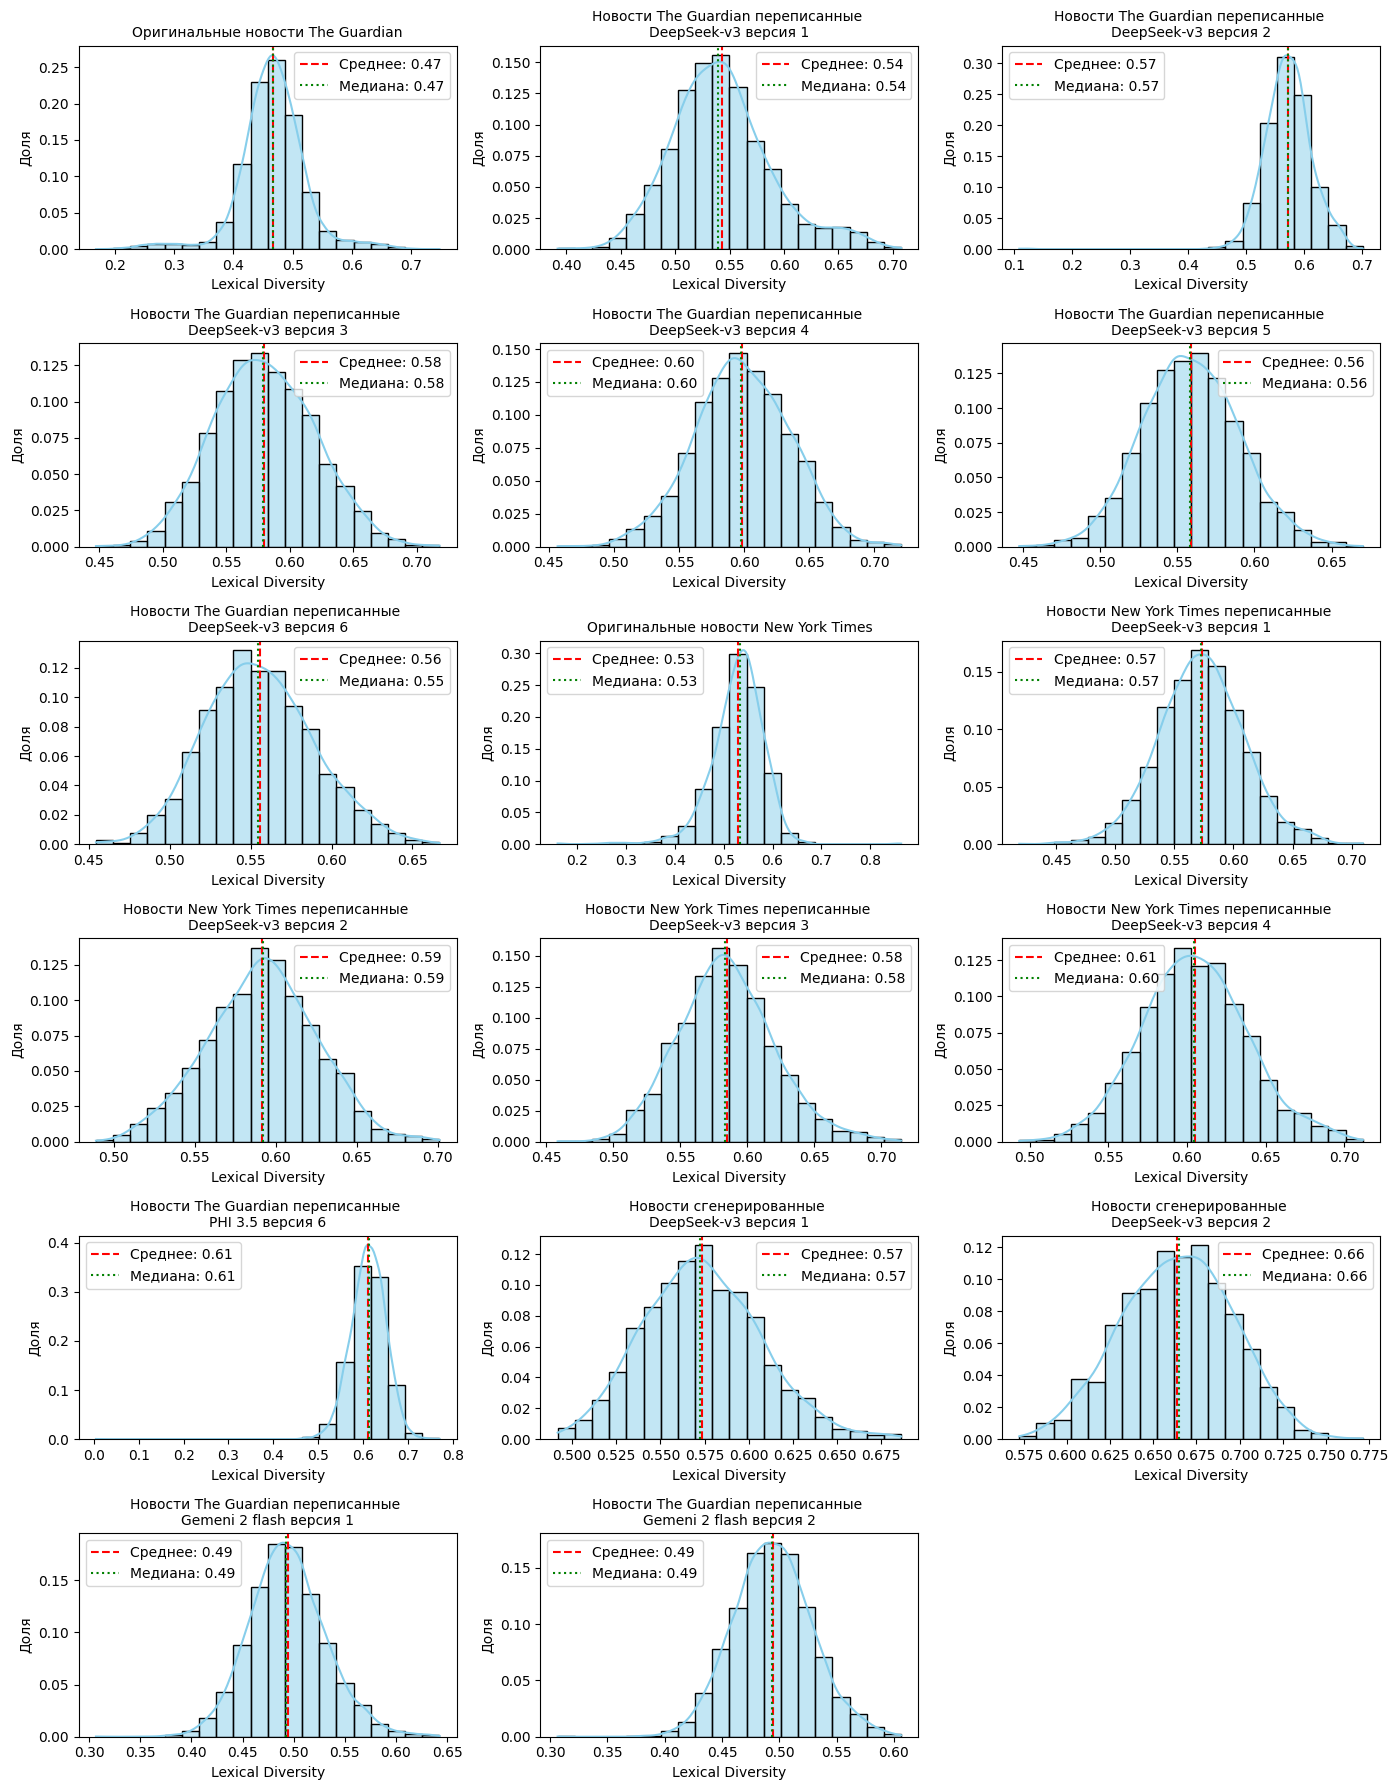

In [47]:
# Рассчет
lexical_diverity_data = {}

for type_paper in tqdm(news_dataset['describ'].unique(), desc=type_paper):

  paper_array = news_dataset[news_dataset['describ']==type_paper]['paper'].values
  lexical_diverity_data[type_paper] = list()

  for paper in paper_array:
    lexical_diverity_data[type_paper].append(
        lexical_diversity(paper)
    )

# Построение 15 графиков с распределением помоценке лексического разнообразия
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(14, 18))
axes = axes.flatten()

for idx, gen_type in enumerate(lexical_diverity_data.keys()):
    ax = axes[idx]
    values = lexical_diverity_data[gen_type]
    gen_type = gen_type_map[gen_type]

    sns.histplot(values, kde=True, ax=ax, bins=20, color='skyblue', edgecolor='black', stat='probability')
    mean_val = np.mean(values)
    median_val = np.median(values)

    ax.axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle=':', label=f'Медиана: {median_val:.2f}')
    ax.set_title(gen_type, fontsize=10)
    ax.set_xlabel('Lexical Diversity')
    ax.set_ylabel('Доля')
    ax.legend()

# Удалим лишние оси, если количество подграфиков меньше 15
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [48]:
save_s3(pickle_data=news_dataset, object_key='news_dataset_for_train_model.pkl', client_s3=client_s3)

In [26]:
#
news_dataset_for_train_model = try_load(
    file_path=PATH+'data/',
    file_name='news_dataset_for_train_model.pkl',
    client_s3=client_s3
    )

news_dataset_for_train_model

Load pdf from s3: original news


,key,describ,paper,generated_flg,augment_data,cut_news
0,politics/article/2024/jun/27/reform-uk-activis...,guardian_orig,A Reform UK activist in the constituency where...,0,0,0
1,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_1,The Reform UK party has been plunged into fres...,1,0,0
2,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_2,"The seaside town of Clacton-on-Sea, where Nige...",1,0,0
3,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_3,Undercover footage from Nigel Farage’s Reform ...,1,0,0
4,politics/article/2024/jun/27/reform-uk-activis...,guardian_rw_dsv3_4,The pub chatter in Clacton-on-Sea took a dark ...,1,0,0
...,...,...,...,...,...,...
57758,world/2024/dec/15/mps-fear-government-too-trus...,guardian_orig,MPs fear the government is moving too fast to ...,0,1,1
57759,world/2024/feb/21/while-people-die-in-gaza-the...,guardian_orig,"Just when you hoped you’d reached rock bottom,...",0,1,1
57760,world/2024/jan/12/no-immediate-plans-for-furth...,guardian_orig,Rishi Sunak has said he will make a statement ...,0,1,1
57761,world/article/2024/aug/28/labour-economic-ties...,guardian_orig,Before a whistlestop European tour to Berlin a...,0,1,1
